In [0]:
# https://keras.io/
!pip install -q keras

In [2]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# Assignment 2

by Group 16:
Irene Septyo Rini Panuju (1023811) &
Robin Esposito (1280155)

***

## Question 1: Neural Codes & Nearest Neighbor retrieval (7.5pt)
The Caltech101 dataset consists of images of 101 different objects. In this question you will develop an image retrieval system using image representations (neural codes) learned with a deep convolutional neural network and a given distance metric.

In the tasks below you will need to implement the following steps:

* Retrieval for $n$ selected (distinct) query images from the dataset
    * For each query image, obtain the 5 most similar images (excluding the query image itself!)
* Evaluation of the quality of the retrieval 
    * The Caltech101 images are annotated with their object class. Use these annotations to evaluate the accuracy of the retrieval task.
    * For each query image, count the number of images whose class corresponds to the one from the query. The score of the retrieval for that image then ranges between:
        * **5** *all* retrieved images' classes agree with the query image class
        * **0** *none* of the images' classes agree with the query image class
    * Compute the average of all $n$ queries

***

### Task 1.1:  Neural codes image retrieval
**a)** Implement the retrieval task and evaluate the results for $n=200$ images. Use the provided VGG16 network pre-trained on ImageNet to compute "neural codes" and L2-distance. Specifically use the codes produces by the following layers of the model: 
1. the "fc1"-layer
2. the "fc2"-layer

Provide the retrieval evaluation scores for both tasks.

In [0]:
# you'll need these imports:
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle

In [5]:
# NOTE: you will first need to apply some changes to "Practical-3.3.0_preprocess-caltech101.ipynb" and run it
#       to obtain a pickle file with "fc1"-features. You don't need to show these changes here.


# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
for datapath in ("caltech101_VGG16_fc1.p","caltech101_VGG16_fc2.p"):
    # load the dataset
    with open(os.path.join("drive/Recommender Systems/data", datapath), "rb") as f:
        X_fc, y, X_paths, classes = pickle.load(f)


    # === SOLUTION: ===
    scores = []
    neigh = NearestNeighbors(n_neighbors=6, p=2)
    neigh.fit(X_fc)
    
    X = X_fc[indices]
    nn = neigh.kneighbors(X)
    
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
      query_score = 0
      for dist, j in zip(distances, nn_indices):
        if(i!=j and classes[y[i]]==classes[y[j]]):
          query_score += 1
      scores.append(query_score)
      
    print("Score for the layer '{}':\t{}".format(datapath, sum(scores) / float(len(scores))))

Score for the layer 'caltech101_VGG16_fc1.p':	3.535
Score for the layer 'caltech101_VGG16_fc2.p':	3.825


***

**b)** Which representation ("neural code") provided better features for the given retrieval task? 
Justify your answer and discuss possible reasons for the observed results. Relate your answer to the conclusions in the paper "Neural Codes for Image Retrieval".

**Answer:**

After running 200 random queries over the two models several times, it resulted that the model that uses the "Fc2" weights performs consistently better than the "Fc1". This is somewhat contradictory to the results reported in the paper: in "Neural Codes for Image Retrieval", it is reported that the layer that performs the best is the first fully connected layer (L6) [Chapter 3], while in our case the best performance is given by the second fully connected layer Fc2 (which would correspond to L7). This difference could be caused by a different nature of the images in the database we used.

In fact, in the paper it is stated that for some paricular queries L7 does have a better performance than both L5 and L6, presumably because it responds better to high-level concepts [Figure 3 in the paper]. This could justify our results.

***

### Task 1.2: Detailed evaluation
**a)** The retrieval scores can vary from one query image to another. Some images are quite representative and for them retrieval works well, some are not so much.
For the same retrieval task given above using "fc2"-features, find (if possible) six query images such that they range from excellent to poor retrieval performance. More specifically find example query images that result in query scores of exactly 0, 1, 2, 3, 4, and 5.

Visualise the six (or less) resulting query images.

In [5]:
# you'll need these extra imports:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Example query with score 0


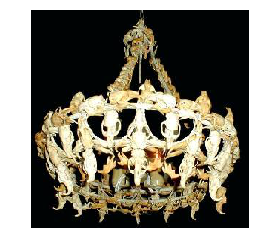

Non-matching results:


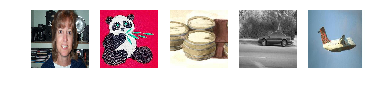

___________________________________________


Example query with score 1


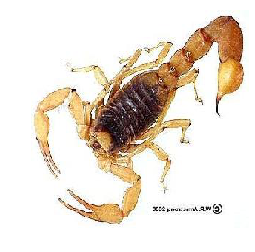

Matching results:


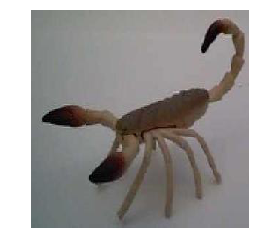

Non-matching results:


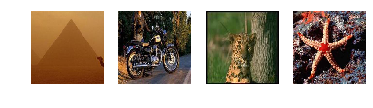

___________________________________________


Example query with score 2


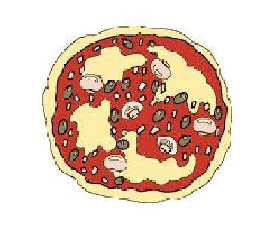

Matching results:


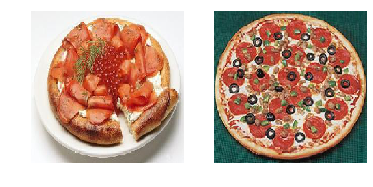

Non-matching results:


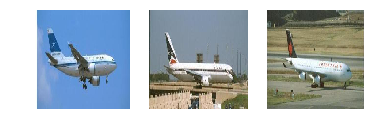

___________________________________________


Example query with score 3


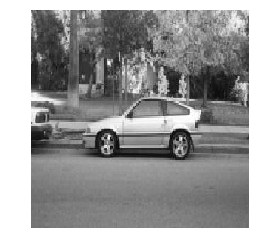

Matching results:


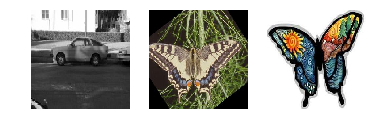

Non-matching results:


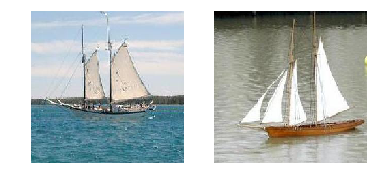

___________________________________________


Example query with score 4


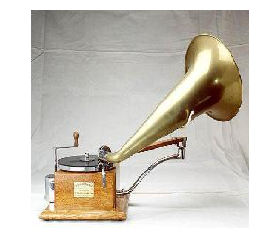

Matching results:


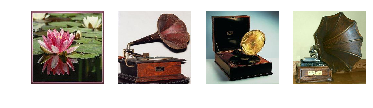

Non-matching results:


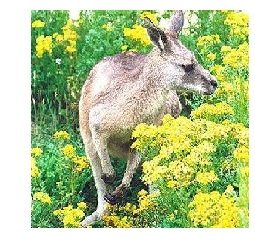

___________________________________________


Example query with score 5


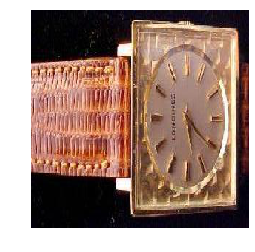

Matching results:


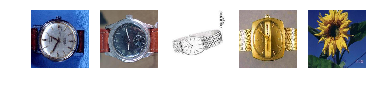

___________________________________________




In [0]:
# load the dataset
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("drive/Recommender Systems/data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)

# you can use this simple function to visualise an image, given a filepath
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.draw()
# example usage given some index < 8677:
#index = 254
#show_img(X_paths[index])


# === SOLUTION: ===
n_examples = 8677
indices = np.random.choice(range(n_examples), size=50, replace=False)
example_queries = []

neigh = NearestNeighbors(n_neighbors=6, p=2)
neigh.fit(X_fc)    
X = X_fc[indices]
nn = neigh.kneighbors(X)

#find one example query for each score
for wanted_score in range(6):  
  for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
    query_score = 0
    matching = []
    not_matching = []
    for dist, j in zip(distances, nn_indices):
      if(i!=j and classes[y[i]]==classes[y[j]]):
        query_score += 1
        matching.append(j)
      elif (i!=j):
        not_matching.append(j)

    if query_score == wanted_score:
      example = {}
      example['query'] = i
      example['matching'] = matching
      example['not_matching'] = not_matching
      example_queries.append(example)
      break
    
#show example queries, with matching and non-matching results
for i,query in enumerate(example_queries):
  print("Example query with score {}".format(i))
  show_img(X_paths[query['query']])
  plt.show()
  
  if query['matching']:
    print("Matching results:")
    fig = plt.figure()
    for n,img_index in enumerate(query['matching']):
      fig.add_subplot(1, len(query['matching']), n+1)
      show_img(X_paths[img_index])
    plt.show()
    
  if query['not_matching']:
    print("Non-matching results:")
    fig = plt.figure()
    for n,img_index in enumerate(query['not_matching']):
      fig.add_subplot(1, len(query['not_matching']), n+1)
      show_img(X_paths[img_index])
    plt.show()
    
  print("___________________________________________\n\n")

***

**b)** Looking at the results, what can you say about the "types" of images that obtain good retrieval scores compared to those obtaining poor retrieval scores? Give an explanation and possible solution(s).

(*HINT: How did we obtain data representations for similarity measures?*)

**Answer:**



The data representation was obtained by training the VGG16 model over the Caltech101 dataset, and then using the weights from the Fc2 layer. Since the network was trained on those specific classes, one possible reason for better or worse performance could be how much the query image is representative of its class. For example, a very realistic painting of a flower could belong to the class "painting", but when retrieving similar images the model would presumably return images from the class "flower", resulting in a low score. Contrarly, a clear image of a cat, belonging to the class "cat", will probably result in a high score.

One other possible reason could be the nature itself of the image: as seen in the previous section, the Fc2 layer performs better in the recognition of high-level concept, therefore the retrieval task will have better results on this kind of images.

***

### Task 1.3: Subjective evaluation
We will now use the "fc2"-features to do image retrieval for query images from the "BACKGROUND_Google" set from the Caltech101 dataset. These images are not associated to a particular class, so we will evaluate them subjectively instead.

**a)** Find two query images from the "BACKGROUND_Google" class, such that for the first query image relevant/similar images are retrieved (according to your own definition of relevancy/similarity), and for the second image mainly irrelevant/dissimilar images are retrieved. For each of them, visualise its 5 nearest neighbors in the Caltech101 dataset (*so do NOT retrieve images from the "BACKGROUND_Google" class!*), according to the "fc2-features" and L2-distance.

Good example (index 429):


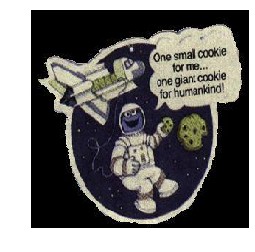

Results from the Caltech101 dataset:


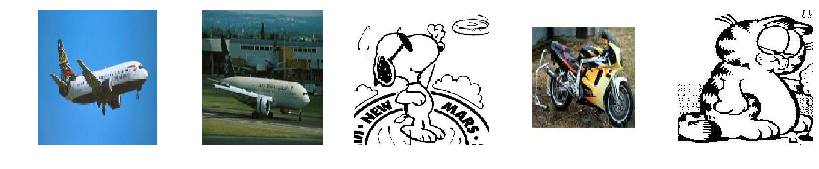




Bad example (index 391):


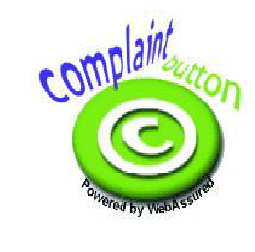

Results from the Caltech101 dataset:


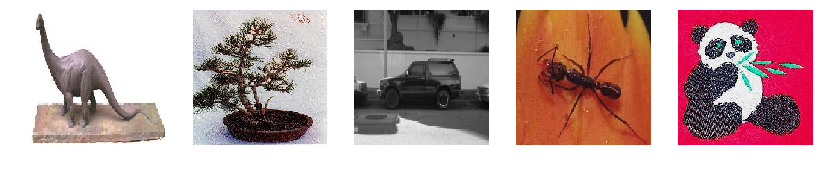

In [0]:
# load the BACKGROUND_Google set
with open(os.path.join("drive/Recommender Systems/data","caltech101_VGG16_fc2_bg.p"), "rb") as f:
    bg_fc2, bg_paths = pickle.load(f)

# load the Caltech101 dataset
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("drive/Recommender Systems/data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)

# === SOLUTION: ===
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.draw()
  
neigh = NearestNeighbors(n_neighbors=5, p=2)
neigh.fit(X_fc) 


#good example
good_index = 429
nn = neigh.kneighbors(bg_fc2[good_index].reshape(1, -1))

print("Good example (index {}):".format(good_index))
show_img(bg_paths[good_index])
plt.show()

print("Results from the Caltech101 dataset:")
nn_indices =  nn[1][0]
fig = plt.figure(figsize=(14,4))
for count, j in enumerate(nn_indices):
  fig.add_subplot(1, len(nn_indices), count+1)
  show_img(X_paths[j])
plt.show()
  
print("\n\n")
  
  
#bad example
bad_index = 391
nn = neigh.kneighbors(bg_fc2[bad_index].reshape(1, -1))

print("Bad example (index {}):".format(bad_index))
show_img(bg_paths[bad_index])
plt.show()

print("Results from the Caltech101 dataset:")
nn_indices =  nn[1][0]
fig = plt.figure(figsize=(14,4))
for count, j in enumerate(nn_indices):
  fig.add_subplot(1, len(nn_indices), count+1)
  show_img(X_paths[j])
plt.show()

***

**b)** Motivate your idea of "relevance": why do you consider the results for the first image relevant/similar, and those for the second image irrelevant/dissimilar?

**Answer:**

As an example of relevant retrieval we selected image 429, which shows a drawing of a spaceship and an astronaut. The retrieved images seem to be quite relevant: two of them represent airplanea, which are similar in shape to the spaceship, and other two are drawings, with similar style to the inputted image. Contrarly, the images retrieved for the second example (391) have no link at all to the query.

***

**c)** Explain why you think this retrieval method (nearest neighbor for neural codes from VGG16) performs better on the first image than on the second.

**Answer:**

The different performances are probably caused by the fact that the Caltech101 dataset contained classes fit to describe the first image (e.g. "airplane"), but not the second one. Since the model was trained on those classes, it has more chances to correctly identify similar images in the first case, while in the second case the query image is quite different from all the images that the model has been trained on.

***

### Task 1.4: Dimensionality reduction

**a)** So far we've been using 4096-dimensional neural codes. This space is however still quite high-dimensional. Apply a dimensionality reduction method and evaluate the effect on the retrieval performance.

* Use PCA to obtain lower-dimensional representations of the Caltech101 data "fc2"-features (try the same compression rates as in Table 2 of the "Neural Codes for Image Retrieval" paper).
* Evaluate the same retrieval task as explained at the start of this question for each of the compression rates/dimensionalities. Report the retrieval scores.

*HINT: See http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html on how to transform a dataset with PCA.*

In [0]:
# import PCA from scikit-learn
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle

In [25]:
# load the data
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("drive/Recommender Systems/data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)
    
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)


# === SOLUTION: ===

#uncompressed score for comparison
scores = []
neigh = NearestNeighbors(n_neighbors=6, p=2)
neigh.fit(X_fc)
    
X = X_fc[indices]
nn = neigh.kneighbors(X)
    
for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
  query_score = 0
  for dist, j in zip(distances, nn_indices):
    if(i!=j and classes[y[i]]==classes[y[j]]):
      query_score += 1
  scores.append(query_score)
      
print("Original score (no reduction):\t{}".format(sum(scores) / float(len(scores))))


#scores for increasing reduction
for dim in [512,256,128,64,32,16]:
  pca = PCA(n_components=dim)
  pca.fit(X_fc)
  X_fc_red = pca.transform(X_fc)

  scores = []
  neigh = NearestNeighbors(n_neighbors=6, p=2)
  neigh.fit(X_fc_red)
    
  X = X_fc_red[indices]
  nn = neigh.kneighbors(X)
    
  for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
    query_score = 0
    for dist, j in zip(distances, nn_indices):
      if(i!=j and classes[y[i]]==classes[y[j]]):
        query_score += 1
    scores.append(query_score)
      
  print("Score for dimension '{}':\t{}".format(dim, sum(scores) / float(len(scores))))

Original score (no reduction):	3.935
Score for dimension '512':	4.035
Score for dimension '256':	4.055
Score for dimension '128':	4.045
Score for dimension '64':	4.035
Score for dimension '32':	3.925
Score for dimension '16':	3.745


***

**b)** Discuss your results: how much can you further reduce the dimensionality of the data representations, without affecting the retrieval performance (much)? Compare these results to those from the paper, are your conclusions similar or not?

**Answer:**

We observed that, in most cases, the codes with dimensionality reduction perform even better than the original ones. The performances remain more or less stable when reducing the dimensions up to 64 (in some test cases they even improve), then they gracefully degrade. Our results show quite a difference from the ones in the papers, since their reported performances never improve with reduction, while ours do. They are instead similar for extreme reductions, which cause a gradual degradation of performances.

***

## Question 2: Fashion-MNIST (12.5pt)
For this question we will work with the "Fashion-MNIST" dataset. This dataset is modelled to have the same specifics as MNIST; it consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 28x28 greyscale image, associated with a label from one of 10 classes. The images represent various clothing items (as opposed to handwritten digits for MNIST), each class represents a different type of clothing item. The following classes exist:
* 0:	T-shirt/top
* 1:	Trouser
* 2:	Pullover
* 3:	Dress
* 4:	Coat
* 5:	Sandal
* 6:	Shirt
* 7:	Sneaker
* 8:	Bag
* 9:	Ankle boot

In this question we will investigate various ways to model visual similarity for this dataset, in order to perform image retrieval. For more info about the dataset, see https://github.com/zalandoresearch/fashion-mnist.

The dataset can directly be obtained through Keras:

Using TensorFlow backend.


4423680/4422102 [==============================] - 3s 1us/step
X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


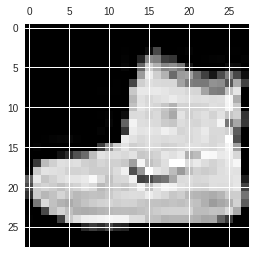

Class: Ankle boot (9)


In [3]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle

# load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# properties of the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# show an example
example_id = 0  # pick any integer from 0 to 59999 to visualize a training example
example = x_train[example_id].reshape(img_rows, img_cols)
label = y_train[example_id]
label_digit = y_train_digits[example_id]
label_class = classes[label_digit]
plt.matshow(example, cmap="gray")
plt.show()
print("Class: {} ({})".format(label_class, label_digit))

Consider the following situation: We have a fully labelled dataset (the ***labelled set***) of the images from the first 5 classes (t-shirts/tops, trousers, pullovers, dresses, coats). We are then supplied with an unlabelled dataset (the ***retrieval set***) containing the remaining Fashion-MNIST images (sandals, shirts, sneakers, bags, ankle boots) on which we want to be able to perform image retrieval. So we cannot use labels from the retrieval set, since we do not know them (note that in our case we *do* have the labels, but we will only use them for evaluation).

The following code splits the dataset up into two sets representing 5 classes each. Observe that the labelled and the retrieval set have exactly the same size.

In [4]:
# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 5).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 5).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 5).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 5).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :5]
y_train_r = y_train_r[:, 5:]
y_test_l = y_test_l[:, :5]
y_test_r = y_test_r[:, 5:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000, 5)
(30000, 5)
(30000,)
(30000,)
(5000, 28, 28, 1)
(5000, 28, 28, 1)
(5000, 5)
(5000, 5)
(5000,)
(5000,)


***

### Task 2.1: Fashion neural retrieval
**a)** Design an MLP (multilayer perceptron) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use `x_train_l` for training). You may include Dropout and BatchNormalization if needed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train it to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 90%) on the labelled test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import sequential model and layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

In [9]:
mlp = Sequential()

# === SOLUTION: ===
mlp.add(Dense(128, activation="relu", input_shape=input_shape))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.2))

mlp.add(Flatten())
mlp.add(Dense(128, activation='relu', name="neural_codes"))
mlp.add(BatchNormalization())
mlp.add(Dropout(0.5))
mlp.add(Dense(5, activation='softmax'))

mlp.summary()

mlp.compile(optimizer="adadelta", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28, 28, 128)       256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
neural_codes (Dense)         (None, 128)               12845184  
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [10]:
# train the model
mlp.fit(x_train_l, y_train_l,
          epochs=20,
          batch_size=100,
          validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 18s 654us/step - loss: 0.4753 - acc: 0.8326 - val_loss: 0.3842 - val_acc: 0.8700
Epoch 2/20
21600/27000 [=======================>......] - ETA: 3s - loss: 0.3646 - acc: 0.871527000/27000 [==============================] - 16s 595us/step - loss: 0.3628 - acc: 0.8722 - val_loss: 0.3169 - val_acc: 0.8827
Epoch 3/20
27000/27000 [==============================] - 16s 592us/step - loss: 0.3374 - acc: 0.8816 - val_loss: 0.2963 - val_acc: 0.8857
Epoch 4/20
 9700/27000 [=========>....................] - ETA: 9s - loss: 0.3423 - acc: 0.8761 27000/27000 [==============================] - 16s 598us/step - loss: 0.3218 - acc: 0.8846 - val_loss: 0.2886 - val_acc: 0.8940
Epoch 5/20
27000/27000 [==============================] - 16s 593us/step - loss: 0.3047 - acc: 0.8920 - val_loss: 0.2802 - val_acc: 0.8933
Epoch 6/20
 7000/27000 [======>.......................] - ETA: 11s - loss: 0.2911 - acc: 

In [11]:
# evaluate the model
loss, accuracy = mlp.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.28810644602775576
Test accuracy: 0.9026


In [0]:
# create directory if doesn't exist yet
try:
    os.mkdir("drive/Recommender Systems/assignment2_models")
except(FileExistsError):
    pass

# save the model
mlp.save(os.path.join("drive/Recommender Systems/assignment2_models", "mlp_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

To make an MLP, we need to use at least 2 hidden layers. Both layers use 128 dimensions (when we tried using 256 dimensions in the first layer, the accuracy did not reach 90%). At the end of the first hidden layer we flatten the 4-dimensional results before passing them to the second hidden layer. Then for each hidden layer we use ReLU activation function, which allows fast and effective training of deep neural networks. We also use BatchNormalization in each layer to ensure that the activations are well distributed, as well as Dropout to prevent overfitting.

Finally, MNIST is a multiclass classification problem, so we use Softmax activation function at the output layer, with 5 dimensions. This way, we can have probability distribution of the first 5 classes in the result.


***

### Task 2.2: Fashion neural retrieval #2
**a)** Design a CNN (convolutional neural network) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use x_train_l for training), consisting of a number of Convolutions with Max-Pooling, followed by one or more Dense layers. You may use Dropout and BatchNormalization to improve generalization and training speed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train the CNN to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 94%) on the test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import additional layers
from keras.layers import Conv2D, MaxPooling2D

In [14]:
cnn = Sequential()

# === SOLUTION: ===
cnn.add(Conv2D(28, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Conv2D(56, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu', name="neural_codes"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation='softmax'))

cnn.summary()

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 28)        112       
_________________________________________________________________
dropout_3 (Dropout)          (None, 26, 26, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 56)        14168     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 56)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 56)        224       
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 56)        0         
__________

In [15]:
# train the model
batch_size = 100
epochs = 20

cnn.fit(x_train_l, y_train_l,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 8s 296us/step - loss: 0.4346 - acc: 0.8470 - val_loss: 0.3981 - val_acc: 0.8303
Epoch 2/20
27000/27000 [==============================] - 7s 268us/step - loss: 0.2960 - acc: 0.8928 - val_loss: 0.2845 - val_acc: 0.8900
Epoch 3/20
21000/27000 [======================>.......] - ETA: 1s - loss: 0.2600 - acc: 0.905627000/27000 [==============================] - 7s 270us/step - loss: 0.2597 - acc: 0.9046 - val_loss: 0.2458 - val_acc: 0.9070
Epoch 4/20
27000/27000 [==============================] - 7s 268us/step - loss: 0.2405 - acc: 0.9132 - val_loss: 0.2817 - val_acc: 0.8903
Epoch 5/20
27000/27000 [==============================] - 7s 271us/step - loss: 0.2159 - acc: 0.9223 - val_loss: 0.3330 - val_acc: 0.8700
Epoch 6/20
 7900/27000 [=======>......................] - ETA: 4s - loss: 0.2094 - acc: 0.924227000/27000 [==============================] - 7s 269us/step - loss: 0.2056 - acc: 0

In [16]:
# evaluate the model
loss, accuracy = cnn.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.1575115844130516
Test accuracy: 0.9466


In [0]:
# save the model
cnn.save(os.path.join("drive/Recommender Systems/assignment2_models", "cnn_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

We decided to use not more than 2 convolutional convolutional layers for the CNN to keep the network shallow, therefore preventing unpredictable results. The first convolutional layer use 28 dimensions (because the input images are 28x28) while the second one uses 56 dimensions. As specified in the question, before the output layer, there is also a hidden dense layer using 128 dimensions. Then for each hidden layer we use ReLU activation function, which allows fast and effective training of deep neural networks. We also use BatchNormalization and Dropout in each layer to ensure that the activations are well distributed.

Finally, MNIST is a multiclass classification problem, so we use Softmax activation function at the output layer, with 5 dimensions. This way, we can have probability distribution of the first 5 classes in the result.

***

### Task 2.3: Fashion neural retrieval #3
**a)** Design a (convolutional) Denoising Autoencoder (DAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the DAE to reconstruct noisy images to the original input images. Make sure that it achieves a binary cross-entropy loss of at most 0.29 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import additional layer
from keras.layers import UpSampling2D, Reshape

In [0]:
# obtain noisy version of data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [17]:
# define autoencoder
dae = Sequential()

# === SOLUTION: ===
dims = 28

# encoder
dae.add(Conv2D(dims, (3, 3), activation='relu', padding='same', input_shape=input_shape))
dae.add(MaxPooling2D((2, 2), padding='same'))
dae.add(BatchNormalization())
dae.add(Conv2D(dims, (3, 3), activation='relu', padding='same'))
dae.add(MaxPooling2D((2, 2), padding='same'))
dae.add(BatchNormalization())
dae.add(Flatten())
dae.add(Dense(128, activation='relu', name="neural_codes"))


# decoder
flat_dims = 7 * 7 * dims
dae.add(Dense(flat_dims))
dae.add(Reshape((7, 7, dims)))
dae.add(Conv2D(dims, (3, 3), activation='relu', padding='same'))
dae.add(UpSampling2D((2, 2)))
dae.add(BatchNormalization())
dae.add(Conv2D(dims, (3, 3), activation='relu', padding='same'))
dae.add(UpSampling2D((2, 2)))
dae.add(BatchNormalization())
dae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

dae.summary()
dae.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 28)        112       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 28)        7084      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 28)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 28)          112       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1372)              0         
__________

In [38]:
# train the model
dae.fit(x_train_noisy, x_train,
                batch_size=100,
                epochs=20,
                validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 14s 256us/step - loss: 0.3303 - val_loss: 0.3037
Epoch 2/20
54000/54000 [==============================] - 13s 241us/step - loss: 0.2958 - val_loss: 0.2962
Epoch 3/20
25000/54000 [============>.................] - ETA: 6s - loss: 0.291854000/54000 [==============================] - 13s 241us/step - loss: 0.2919 - val_loss: 0.2931
Epoch 4/20
54000/54000 [==============================] - 13s 240us/step - loss: 0.2894 - val_loss: 0.2937
Epoch 5/20
54000/54000 [==============================] - 13s 240us/step - loss: 0.2879 - val_loss: 0.2907
Epoch 6/20
 5000/54000 [=>............................] - ETA: 11s - loss: 0.288954000/54000 [==============================] - 13s 241us/step - loss: 0.2867 - val_loss: 0.2899
Epoch 7/20
54000/54000 [==============================] - 13s 241us/step - loss: 0.2858 - val_loss: 0.2890
Epoch 8/20
54000/54000 [==============================] - 13s 2

In [39]:
test_loss = dae.evaluate(x_test_noisy, x_test, batch_size=100)
print("Test loss:", test_loss)

x_test_reconstr = dae.predict(x_test_noisy, batch_size=100)

10000/10000 [==============================] - 1s 80us/step
Test loss: 0.2875428166985512


In [0]:
# save the model
dae.save(os.path.join("drive/Recommender Systems/assignment2_models", "dae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

In designing the encoder and decoder, we aim for the 'funnel' model, where the size of the layers on the encoder is mirrored by the decoder. In our case, the encoder consists of a CNN with 2 convolutional layers: the first layer uses 28 dimensions (because an image input is 28x28), and the second layer uses 56 dimensions. Both convolutional layers use MaxPooling to reduce the number of parameters, and BatchNormalization ensure that the activations are well distributed. At the last layer of the encoder, the layer is flattened in order to get the encoded representation of the data.

Being the mirror of the encoder, the decoder also consists of a CNN with 2 convolutional layers. Because the input of the decoder is flattened, the data needs to be first reshaped to its original dimensionality, then processed through a 56-dimensions convolutional layer and then 28-dimensions one. BatchNormalization are used in both layers for the same reason as in the encoder. However, instead of MaxPooling, we use UpScaling instead to get the original parameters. At the output layer of the encoder, Sigmoid activation is used because the results are in binary data (i.e. whether a pixel belongs to the original picture or not).

***

Visualise a few test examples, their noisy versions, and their reconstructions.

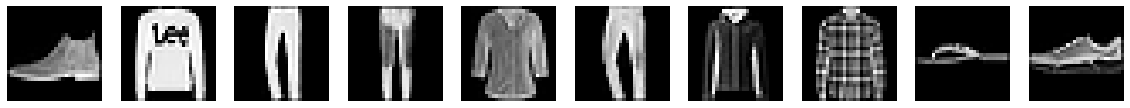

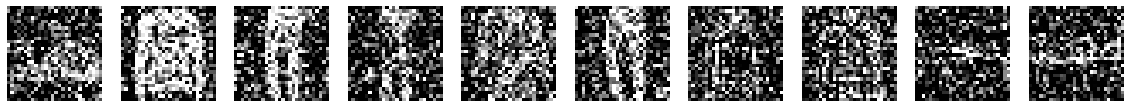

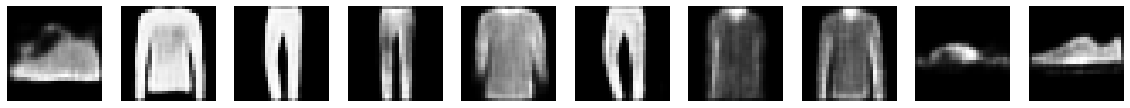

In [24]:
batch_size = 100

# NOTE: you don't need to change this code, just run it after having trained the DAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = dae.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr)

**c)** Do you consider the results acceptable? Do you think they can be useful for image retrieval? Explain why in one or two sentences.

**Answer:**

We think that the results are still not very useful because some images still have quite big loss, e.g. the 'Lee' t-shirt does not have the logo anymore, and the checkered shirt completely lost its pattern details. So if the query involves these details, i.e. "Lee t-shirts" or "checkered shirts", then the search will fail; however, for simpler queries like "t-shirts" or "shoes", these results might still be useful.

***

**d)** Why can we train on the full dataset `x_train` here, whereas in Tasks 2.1 and 2.2 we had to use `x_train_l` (the first 5 classes only) for training?

**Answer:**

In Tasks 2.1 and 2.2 we have used Softmax activation function at the output layer that uses 5 dimensions, which outputs 5 classes. This allows us to know what are the probabilities that an image belongs to the first five classes. If we use the full dataset for training this task, there will be 10 classes in the data, and the model will not be able to classify these classes. Thus, we can only train using `x_train_l` dataset.

On the other hand, we don't classify the images into classes for Task 2.3. What we do is identifying whether a pixel on a noised image belongs to the original picture. This is why we have Sigmoid activation function on the output layer of the decoder. Because we are not classifying the images to the first 5 classes, we can use the full `x_train` dataset for training.

***

### Task 2.4: Fashion neural retrieval #4
Autoencoders come in different shapes and sizes. One key defining property of autoencoders is the means the model uses to prevent the learning of the identity function. Typically, this is done with different regularization methods. In the previous task you used a model that uses noise as a regularizer. In this task you will develop a Sparse Autoencoder (SAE). A sparse autoencoder uses a sparsity regularization to obtain sparse representations of the input data. Sparsity can be achieved by using L1-regularization on the activations of the hidden "code" layer.

**a)** Design a (convolutional) Sparse Autoencoder (SAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). Add an activity regularizer to this layer, using `regularizers.l1(10e-5)` from Keras.
For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the SAE to reconstruct input images. Make sure that it achieves a loss value of at most 0.31 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [0]:
# import regularizers for sparse autoencoder
from keras import regularizers

In [30]:
# define autoencoder
sae = Sequential()

# === SOLUTION: ===
dims = 28

# encoder
sae.add(Conv2D(dims, (3, 3), activation='relu', padding='same', input_shape=input_shape))
sae.add(MaxPooling2D((2, 2), padding='same'))
sae.add(BatchNormalization())
sae.add(Conv2D(dims, (3, 3), activation='relu', padding='same'))
sae.add(MaxPooling2D((2, 2), padding='same'))
sae.add(BatchNormalization())
sae.add(Flatten())
sae.add(Dense(128, activation='relu', activity_regularizer=regularizers.l1(10e-5), name="neural_codes"))


# decoder
flat_dims = 7 * 7 * dims
sae.add(Dense(flat_dims))
sae.add(Reshape((7, 7, dims)))
sae.add(Conv2D(dims, (3, 3), activation='relu', padding='same'))
sae.add(UpSampling2D((2, 2)))
sae.add(BatchNormalization())
sae.add(Conv2D(dims, (3, 3), activation='relu', padding='same'))
sae.add(UpSampling2D((2, 2)))
sae.add(BatchNormalization())
sae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

sae.summary()
sae.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 28)        280       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 14, 14, 28)        112       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 28)        7084      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 28)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 7, 28)          112       
_________________________________________________________________
flatten_5 (Flatten)          (None, 1372)              0         
__________

In [31]:
# train the model
sae.fit(x_train, x_train,
                batch_size=100,
                epochs=20,
                validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 14s 259us/step - loss: 0.3829 - val_loss: 0.3636
Epoch 2/20
54000/54000 [==============================] - 13s 238us/step - loss: 0.3375 - val_loss: 0.3417
Epoch 3/20
26300/54000 [=============>................] - ETA: 6s - loss: 0.332454000/54000 [==============================] - 13s 238us/step - loss: 0.3316 - val_loss: 0.3382
Epoch 4/20
54000/54000 [==============================] - 13s 237us/step - loss: 0.3270 - val_loss: 0.3273
Epoch 5/20
54000/54000 [==============================] - 13s 237us/step - loss: 0.3231 - val_loss: 0.3264
Epoch 6/20
 5700/54000 [==>...........................] - ETA: 11s - loss: 0.321554000/54000 [==============================] - 13s 239us/step - loss: 0.3204 - val_loss: 0.3203
Epoch 7/20
54000/54000 [==============================] - 13s 238us/step - loss: 0.3177 - val_loss: 0.3212
Epoch 8/20
54000/54000 [==============================] - 13s 2

In [40]:
# evaluate the model
test_loss = sae.evaluate(x_test, x_test, batch_size=100)
print("Test loss:", test_loss)

x_test_reconstr = sae.predict(x_test, batch_size=100)

10000/10000 [==============================] - 1s 70us/step
Test loss: 0.2881744465231895


In [0]:
# save the model
sae.save(os.path.join("drive/Recommender Systems/assignment2_models", "sae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

The architecture of the Sparse Autoencoder is very similar to what we did in the previous section for the Denoising Autoencoder: we followed a 'funnel' model, in which the layers of the encoder mirror the layers of the decoder. The main difference between the two is that in this case there is no need to add noise to the data in order to train the model, but we can use the original images. Instead, this Sparse Encoder uses an activity regularizer to avoid learning the identity function. We added the regularizer to the last Dense layer of the encoder, in order to achieve sparsity in the encoded representation of the images.

***

Visualise a few test examples and their reconstructions.

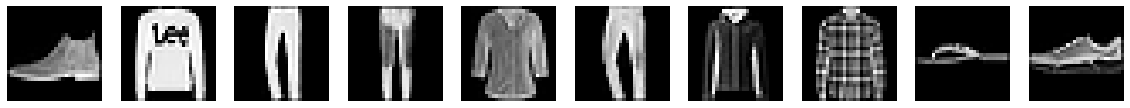

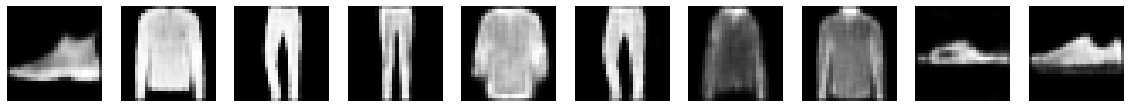

In [42]:
# NOTE: you don't need to change this code, just run it after having trained the SAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = sae.predict(x_test, batch_size=100)

plot_examples(x_test)
plot_examples(x_test_reconstr)

**c)** Compare the visual results to those of the DAE in Task 2.3. Also compare the loss values of the test set for the DAE and SAE. How can you explain the difference?

**Answer:**

By comparing the visual results, we can conclude that the two encoders achieve very similar results, but the SAE performs slighly better than the DAE in reconstructing the input images. The difference is caused by the different ways of preventing the learning of the indentity function in the two models: apparently the autoencoder performs better when sparsity is achieved by using a regularizer, rather than when a random noise is added to the input image. The difference in the perfomances is confirmed by a slighlty lower loss value in the SAE (~0.288) than in the DAE (~0.289).

***

### Task 2.5: Comparison
Obtain 128-dimensional neural code representations of the last five classes of the Fashion-MNIST dataset (the *retrieval set*: `x_train_r`) from the following models/layers:
1. The last dense hidden layer (before the output layer) of the MLP you trained in Task 2.1
2. The last dense hidden layer (before the output layer) of the CNN you trained in Task 2.2
3. The center layer/code of the DAE you trained in Task 2.3
4. The center layer/code of the SAE you trained in Task 2.4
5. A PCA-transformation

In [0]:
# additional imports
from keras.models import load_model
from keras.models import Model
from sklearn.decomposition import PCA

In [44]:
# load the previously trained and saved models
mlp = load_model(os.path.join("drive/Recommender Systems/assignment2_models", "mlp_fashionmnist_l.h5"))
cnn = load_model(os.path.join("drive/Recommender Systems/assignment2_models", "cnn_fashionmnist_l.h5"))
dae = load_model(os.path.join("drive/Recommender Systems/assignment2_models", "dae_fashionmnist.h5"))
sae = load_model(os.path.join("drive/Recommender Systems/assignment2_models", "sae_fashionmnist.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
mlp_nc = Model(inputs=mlp.input, outputs=mlp.get_layer("neural_codes").output)
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes").output)
dae_nc = Model(inputs=dae.input, outputs=dae.get_layer("neural_codes").output)
sae_nc = Model(inputs=sae.input, outputs=sae.get_layer("neural_codes").output)

# obtain flat representations of the data
x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# train PCA on the retrieval set
pca = PCA(n_components=128)
pca.fit(x_train_r_flat)

# obtain 128-dimensional representations
nc_mlp_train = mlp_nc.predict(x_train_r)
nc_mlp_test = mlp_nc.predict(x_test_r)
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)
nc_dae_train = dae_nc.predict(x_train_r)
nc_dae_test = dae_nc.predict(x_test_r)
nc_sae_train = sae_nc.predict(x_train_r)
nc_sae_test = sae_nc.predict(x_test_r)
nc_pca_train = pca.transform(x_train_r_flat)
nc_pca_test = pca.transform(x_test_r_flat)

# print the shapes to confirm all features are 128-dimensional
print(nc_mlp_train.shape)
print(nc_mlp_test.shape)
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)
print(nc_dae_train.shape)
print(nc_dae_test.shape)
print(nc_sae_train.shape)
print(nc_sae_test.shape)
print(nc_pca_train.shape)
print(nc_pca_test.shape)

(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)


***

**a)** Evaluate the retrieval task as described in Question 1 on the last 5 classes (the retrieval set) of the Fashion-MNIST dataset, for the five data representations given above. Use query images from the test set and retrieve images from the training set only. Print the five resulting retrieval scores (between 0 and 5).

*HINT: you can use* `y_train_digits_r` *and* `y_test_digits_r` *to obtain digit encodings (as opposed to one-hot encodings) of the data labels.*

In [45]:
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 5000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

representations = [
    (nc_mlp_train, nc_mlp_test),
    (nc_cnn_train, nc_cnn_test),
    (nc_dae_train, nc_dae_test),
    (nc_sae_train, nc_sae_test),
    (nc_pca_train, nc_pca_test),
]

models = ["MLP", "CNN", "DAE", "SAE", "PCA"]

for (nc_train, nc_test), model in zip(representations, models):
    # === SOLUTION: ===
    scores = []
    neigh = NearestNeighbors(n_neighbors=5, p=2)
    neigh.fit(nc_train)
    
    X = nc_test[indices]
    nn = neigh.kneighbors(X)
    
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
      query_score = 0
      for dist, j in zip(distances, nn_indices):
        if(classes[y_test_digits_r[i]]==classes[y_train_digits_r[j]]):
          query_score += 1
      scores.append(query_score)
      
    print("Score for the model '{}':\t{}".format(model, sum(scores) / float(len(scores))))

Score for the model 'MLP':	4.385
Score for the model 'CNN':	4.55
Score for the model 'DAE':	4.675
Score for the model 'SAE':	4.75
Score for the model 'PCA':	4.72


***

**b)** Compare the "baseline" PCA-transformed data with the other methods. Is PCA a suitable method to obtain representations for image retrieval in this situation? Why do you think so? Would you expect a similar conclusion for the Caltech101 dataset from Question 1?

**Answer:**

From the retrieval scores we obtained, it resulted that PCA is actually a good method to represent the images in this dataset: its score is higher than almost all the other representation methods with the exception of SAE, which is slightly higher. This probably happens because the pictures in the Fashion-MNIST dataset are all very similar: the clothes are photographed from a frontal angle and with a black background. This causes pictures of similar clothes to have a high pixel-to-pixel correspondence, which translates in a good retrieval performance.

We could not expect a similar behaviour when using a dataset such as Caltech101: in that case, pictures belonging to the same class can be very different from each other in colors and shapes, and therefore a more sophisticated representation model is required in order to detect similar features in the dataset. CNN and the Autoencoders would probably have far better performances than PCA, because they are optimized to recognize specific patterns in the images.

***

Observe the difference between encodings from the DAE and SAE.

In [46]:
print("Mean activation for DAE encodings:", np.mean(nc_dae_train))
print("Mean activation for SAE encodings:", np.mean(nc_sae_train))

index = 1  # try a few indices here
print("DAE encoding example:")
print(nc_dae_train[index])
print("SAE encoding example:")
print(nc_sae_train[index])

Mean activation for DAE encodings: 2.823132
Mean activation for SAE encodings: 0.0020227036
DAE encoding example:
[1.0758928e+01 3.2587070e+00 2.9155928e-01 0.0000000e+00 0.0000000e+00
 1.3159344e+00 0.0000000e+00 0.0000000e+00 1.4490613e+01 1.4263861e+01
 3.0414264e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8029380e+00
 1.0610130e+01 0.0000000e+00 3.9938419e+00 1.1495482e+00 4.9766889e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.1148701e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.6618848e+00 6.7655301e+00 0.0000000e+00
 4.1500801e-01 7.7951927e+00 1.8613739e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.1606908e+00 0.0000000e+00 0.0000000e+00
 2.7629213e+00 3.9791594e+00 0.0000000e+00 2.3000090e+00 0.0000000e+00
 1.0157002e+01 5.4675746e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.2267877e+01 0.0000000e+00 4.0745916e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.6712298e+00 0.0000000e+00 3.0055804e+00
 0.0000000e+00 0.0000000e+00 0.000

**c)** Discuss the difference in encodings between the two autoencoders (denoising and sparse). Also discuss the difference in retrieval performance for these encodings. How would you explain this difference?

**Answer:**

Because the encoding of SAE is sparse, there are many zeros that are stored in it, as can be seen on the examples above. With sparse encoding such as SAE, we can get more information easily without having to do additional processing during training or classification, therefore resulting in faster processing. This can be seen from the mean activation score above (DAE: 2.8231, SAE: 0.0020). Thus, if speed of analysis is highly prioritized, SAE encoding should be used.

***

**d)** What is the best performing method you found in part a)? Describe what advantage you believe this method has over the others.

**Answer:**

If we look at the results of 2.4a, we can see that SAE has the highest score of all methods, when performing a retrieval task using Nearest Neighbors. The advantage of SAE is that its goal is to find the most efficient compact representation, to minimize the error when reconstructing the input images. These kind of networks is trained to ignore irrelevant features the input images and to focus on recurring patterns in the pixels, which is why they perform well in image recognition and image retrieval tasks.